<a href="https://colab.research.google.com/github/hazelhkim/Pytorch/blob/master/Manifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load MNIST
def load_mnist(is_train = True, flatten = True):
  from torchvision import datasets, transforms
  dataset = datasets.MNIST(
      root = '../data', train = is_train, download=True,
      transform = transforms.Compose([
        transforms.ToTensor(),
      ])
  )
  # filter out x and y
  x = dataset.data.float()/255.
  y = dataset.targets

  # flatten x data
  if flatten:
    x = x.view(x.size(0), -1)

  return x, y

In [19]:
# Trainer
from copy import deepcopy

def _train(model, optimizer, crit, x, y, config):
  # Set the model as a trianing mode.
  model.train()

  # Shuffle before start.
  indices = torch.randperm(x.size(0), device = x.device)
  x = torch.index_select(x, dim=0, index = indices).split(config.batch_size, dim=0)
  y = torch.index_select(y, dim=0, index = indices).split(config.batch_size, dim=0)

  total_loss = 0

  for i, (x_i, y_i) in enumerate(zip(x, y)):
    y_i_hat = model(x_i)
    loss_i = crit(y_i_hat, y_i.squeeze()) # y_i might have unnecessary extra space other than dim=0.

    # Initialize the gradients of the model.
    optimizer.zero_grad()
    loss_i.backward()
    optimizer.step()

    if config.verbose >= 2:
      print("Train Iteration(%d/%d): loss=%.4e" %(i+1, len(x), float(loss_i)))

      # Don't forget to detach to prevent memory leak.
      total_loss += float(loss_i)

    return total_loss/len(x)


def _validate(model, optimizer, crit, x, y, config):
  # Turn evalutation mode on.
  model.eval()

  # Turn on the no_grad mode to make more efficient
  with torch.no_grad():
    # Shuffle befoer begin.
    indices = torch.randperm(x.size(0), device = x.device)
    x = torch.index_select(x, dim=0, index=indices).split(config.batch_size, dim=0)
    y = torch.index_select(y, dim=0, index=indices).split(config.batch_size, dim=0)

    total_loss = 0

    for i, (x_i, y_i) in enumerate(zip(x, y)):
      y_hat_i = model(x_i)
      loss_i = crit(y_hat_i, y_i.squeeze())

      if config.verbose >= 2:
        print("Valid Iteration (%d/%d): loss = %.4e" %(i+1, len(x), float(loss_i)))

      total_loss += float(loss_i)
      
    return total_loss/len(x)

def train(model, optimizer, crit, train_data, valid_data, config):
  lowest_loss = np.inf
  best_model = None

  for epoch_index in range(config.n_epochs):
    train_loss = _train(model, optimizer, crit, train_data[0], train_data[1], config)
    valid_loss = _validate(model, optimizer, crit, valid_data[0], valid_data[1], config)

    # You must use deep copy to take a snpashot of current best weights.
    if valid_loss <= lowest_loss:
      lowest_loss = valid_loss
      best_model = deepcopy(model.state_dict())

      print("Epoch(%d/%d): train_loss = %.4e valid_loss = %.4e lowest_loss = %.4e" %(
          epoch_index + 1,
          config.n_epochs,
          train_loss,
          valid_loss,
          lowest_loss,
      ))

      # Restore to best model.
      model.load_state_dict(best_model)

In [15]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size' : 256, 
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)
print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [11]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0)*config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim = 0)

train_Y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices,
).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([60000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
test: torch.Size([10000, 784]) torch.Size([10000])


In [12]:
# Autoencoder

class Autoencoder(nn.Module):
    
    def __init__(self, btl_size=2):
        self.btl_size = btl_size
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, btl_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(btl_size, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 28 * 28),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        
        return y


In [20]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

train(model, optimizer, crit, (train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss = 0.0000e+00 valid_loss = 1.1185e-01 lowest_loss = 1.1185e-01
Epoch(2/50): train_loss = 0.0000e+00 valid_loss = 1.1142e-01 lowest_loss = 1.1142e-01
Epoch(3/50): train_loss = 0.0000e+00 valid_loss = 1.1114e-01 lowest_loss = 1.1114e-01
Epoch(4/50): train_loss = 0.0000e+00 valid_loss = 1.1109e-01 lowest_loss = 1.1109e-01
Epoch(11/50): train_loss = 0.0000e+00 valid_loss = 1.1038e-01 lowest_loss = 1.1038e-01
Epoch(12/50): train_loss = 0.0000e+00 valid_loss = 1.0935e-01 lowest_loss = 1.0935e-01
Epoch(13/50): train_loss = 0.0000e+00 valid_loss = 1.0830e-01 lowest_loss = 1.0830e-01
Epoch(14/50): train_loss = 0.0000e+00 valid_loss = 1.0756e-01 lowest_loss = 1.0756e-01
Epoch(15/50): train_loss = 0.0000e+00 valid_loss = 1.0701e-01 lowest_loss = 1.0701e-01
Epoch(16/50): train_loss = 0.0000e+00 valid_loss = 1.0677e-01 lowest_loss = 1.0677e-01
Epoch(17/50): train_loss = 0.0000e+00 valid_loss = 1.0661e-01 lowest_loss = 1.0661e-01
Epoch(18/50): train_loss = 0.0000e+00 valid_los

## Mean value in each space.

In [22]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)
    
    plt.imshow(x, cmap='gray')
    plt.show()

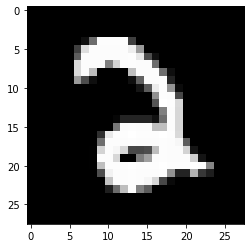

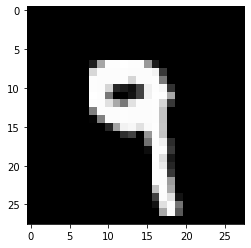

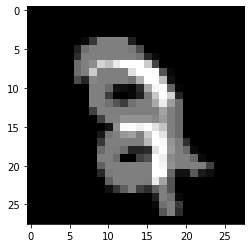

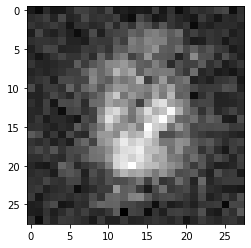

In [23]:
with torch.no_grad():
    import random

    index1 = int(random.random() * test_x.size(0))
    index2 = int(random.random() * test_x.size(0))
    
    z1 = model.encoder(test_x[index1].view(1, -1))
    z2 = model.encoder(test_x[index2].view(1, -1))

    recon = model.decoder((z1 + z2) / 2).squeeze()

    show_image(test_x[index1])
    show_image(test_x[index2])
    show_image((test_x[index1] + test_x[index2]) / 2)
    show_image(recon)